In [1]:
import math
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize

% matplotlib inline

# 0. Moriarty's method

Note that I am using some of the variables in the cell below in subsequent cells

In [47]:
#Moriarty's code
# Ooh look! Parsing for the w07-data.tbl
# This leaves us with
#    N         : number of experiments (columns in the table)
#    G         : number of genes (rows in the table)
#    X[i]      : array of time points, in hrs, for the N experiments
#    S_true[i] : array of sigmas for the experiments
#    Y[i][t]   : GxN: observed tpm for gene i, time point t
#   

#datafile = "w07-data.tbl"
with open("w07-data.tbl.txt", "r") as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)



# Moriarty's method: ordinary least squares on:
#    y_t = b + (a cos p) sin t + (a sin p) cos t
#
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * math.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g])[0]
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians at first
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * math.pi)       # now in hours
    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24



## Output
#
print("{0:12s} {1:>6s} {2:>6s} {3:>6s}".format('genename', 'b', 'a', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s}".format('-'*12, '-'*6,'-'*6,'-'*6))
for g in range(G):
    print("{0:12s} {1:6.2f} {2:6.2f} {3:6.2f}".format(genenames[g], b_fit[g], a_fit[g], p_fit[g]))


genename          b      a      p
------------ ------ ------ ------
anise         40.93  35.17   3.07
kiwi          43.20  23.97  16.27
carrot        40.59  17.89   2.71
grape         51.37  22.54  13.10
tangerine     39.15  28.42   7.89
melon         37.29  22.89   3.16
clementine    40.66  29.24  17.32
spinach       49.06  19.08   0.87
beet          44.21  26.08  11.84
huckleberry   46.09  23.42  23.47
lentil        44.49  18.91   9.14
cauliflower   40.44  23.67  21.64


/Users/Hailey/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:64: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [3]:
print(N)         #: number of experiments (columns in the table)
print(G)         # number of genes (rows in the table)
print(X)      # array of time points, in hrs, for the N experiments
print(S_true) # array of sigmas for the experiments
print(Y)

8
12
[ 4  4  8  8 16 16 24 24]
[20.  2. 20.  5.  5. 20.  2. 20.]
[array([109.77,  72.66,  20.56,  56.19,  25.28,   0.  ,  60.12,  50.41]), array([12.73, 18.81, 54.5 , 45.41, 68.87, 52.19, 20.02, 33.38]), array([62.25, 60.75, 52.48, 36.12, 20.47, 27.77, 59.04, 40.98]), array([15.64, 22.59, 50.08, 35.41, 68.81, 70.85, 35.55, 68.25]), array([47.88, 31.65,  9.36, 20.77, 54.15, 22.44, 56.57, 71.97]), array([52.94, 56.61, 65.61, 24.75, 28.  ,  0.  , 64.52, 49.56]), array([ 2.56, 32.65, 51.08, 55.65, 57.87, 58.38, 11.88, 17.46]), array([84.98, 65.22, 52.5 , 63.15, 34.64, 32.18, 48.84, 47.48]), array([11.93, 25.22, 20.58, 26.43, 60.33, 69.68, 44.47, 51.03]), array([73.92, 60.69, 62.34, 69.59, 39.76, 17.31, 33.45, 48.6 ]), array([49.72, 44.88, 16.71, 24.28, 39.94, 65.69, 62.89, 40.72]), array([49.95, 39.98, 68.16, 66.92, 40.3 , 17.36, 18.78, 41.72])]


# 1. Solve by maximum likelihood

In [4]:
#parse the data using Sean's code - slightly modified for user's ease of use
#datafile = "w07-data.tbl"
with open("w07-data.tbl.txt", "r") as f:
    # First header line gives us the time points
    fields = f.readline().split()
    hrs = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        hrs.append(int(match.group(1)))
    hrs = np.array(hrs)
    N = len(hrs)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    rna = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        rna.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(rna)

In [22]:
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

paras = [1.0, 1.0, 1.0] 

#gene by gene
def nll_hc(params, y, S_true, hrs):
    ll = 0.
    
    a = params[0]
    b = params[1]
    phi = params[2]


    for j in range(len(hrs)):
        #define predicted tpm for each time
        yp = b + a*np.sin(2. * math.pi * (hrs[j] + phi) / 24)
        
        #measure error between predicted value and actual values
        residual = y[j] - yp

        ll      += stats.norm.logpdf(residual, 0, S_true[j])    
    return -ll

In [75]:
a_opt = []
b_opt = []
p_opt = []

for y in Y:
    paras = [1.0, 1.0, 1.0] 
    results = optimize.minimize(nll_hc, paras, (y, S_true, hrs))
    
    if results.success != True:
        sys.exit("Maximum likelihood fit failed")

    a_opt.append(results.x[0])
    b_opt.append(results.x[1])
    p_opt.append(results.x[2])

for i in range(len(Y)):
    if a_opt[i] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_opt[i]  = -a_opt[i]
        p_opt[i] += 12
    while p_opt[i] < 0:  p_opt[i] += 24
    while p_opt[i] > 24: p_opt[i] -= 24

In [76]:
opts = pd.DataFrame([a_opt, b_opt, p_opt], index=['a', 'b', 'phi'], columns=genenames).T

In [77]:
opts.sort_values('phi')

,a,b,phi
spinach,18.120153,49.113598,0.018880
anise,25.164183,46.877705,2.222912
carrot,23.138407,39.648486,3.904267
melon,25.140898,40.100003,5.451115
lentil,22.068071,42.853390,7.679799
tangerine,24.294451,42.668030,9.696870
beet,21.330644,43.517720,11.860551
grape,23.487012,46.542103,13.867982
kiwi,28.429243,44.162598,15.938284
clementine,30.307674,42.998520,18.434850


# 2. Compare solutions

In [78]:
mor = pd.DataFrame([a_fit, b_fit, p_fit], index=['a', 'b', 'phi'], columns=genenames).T

In [79]:
mor.sort_values('phi')

,a,b,phi
spinach,19.082429,49.061667,0.866472
carrot,17.885339,40.587778,2.708109
anise,35.166278,40.926944,3.073257
melon,22.886663,37.289167,3.160582
tangerine,28.419642,39.150000,7.893135
lentil,18.907197,44.489167,9.136236
beet,26.079878,44.210000,11.835912
grape,22.535307,51.374167,13.095663
kiwi,23.967518,43.202222,16.271247
clementine,29.239482,40.657222,17.321532


In [80]:
ll_opt = 0.
ll_mor = 0.

for i,y in enumerate(Y):
    ll_opt += nll_hc(opts.iloc[i], y, S_true, hrs)
    ll_mor += nll_hc(mor.iloc[i], y, S_true, hrs)

print(ll_opt, ll_mor)

(310.54701041357066, 455.14794082845333)


My method is better - my loglikelihood is lower than Moriarty's. 

In [81]:
a_fit.shape

(12,)

# 3. Plot the fits

In [82]:
b_opt

[46.87770495031178,
 44.1625976441489,
 39.64848635637452,
 46.5421026892553,
 42.66803036349729,
 40.10000273398874,
 42.998520441386894,
 49.11359796082287,
 43.51771976195019,
 48.02066354111474,
 42.853389751342625,
 40.856003804225956]

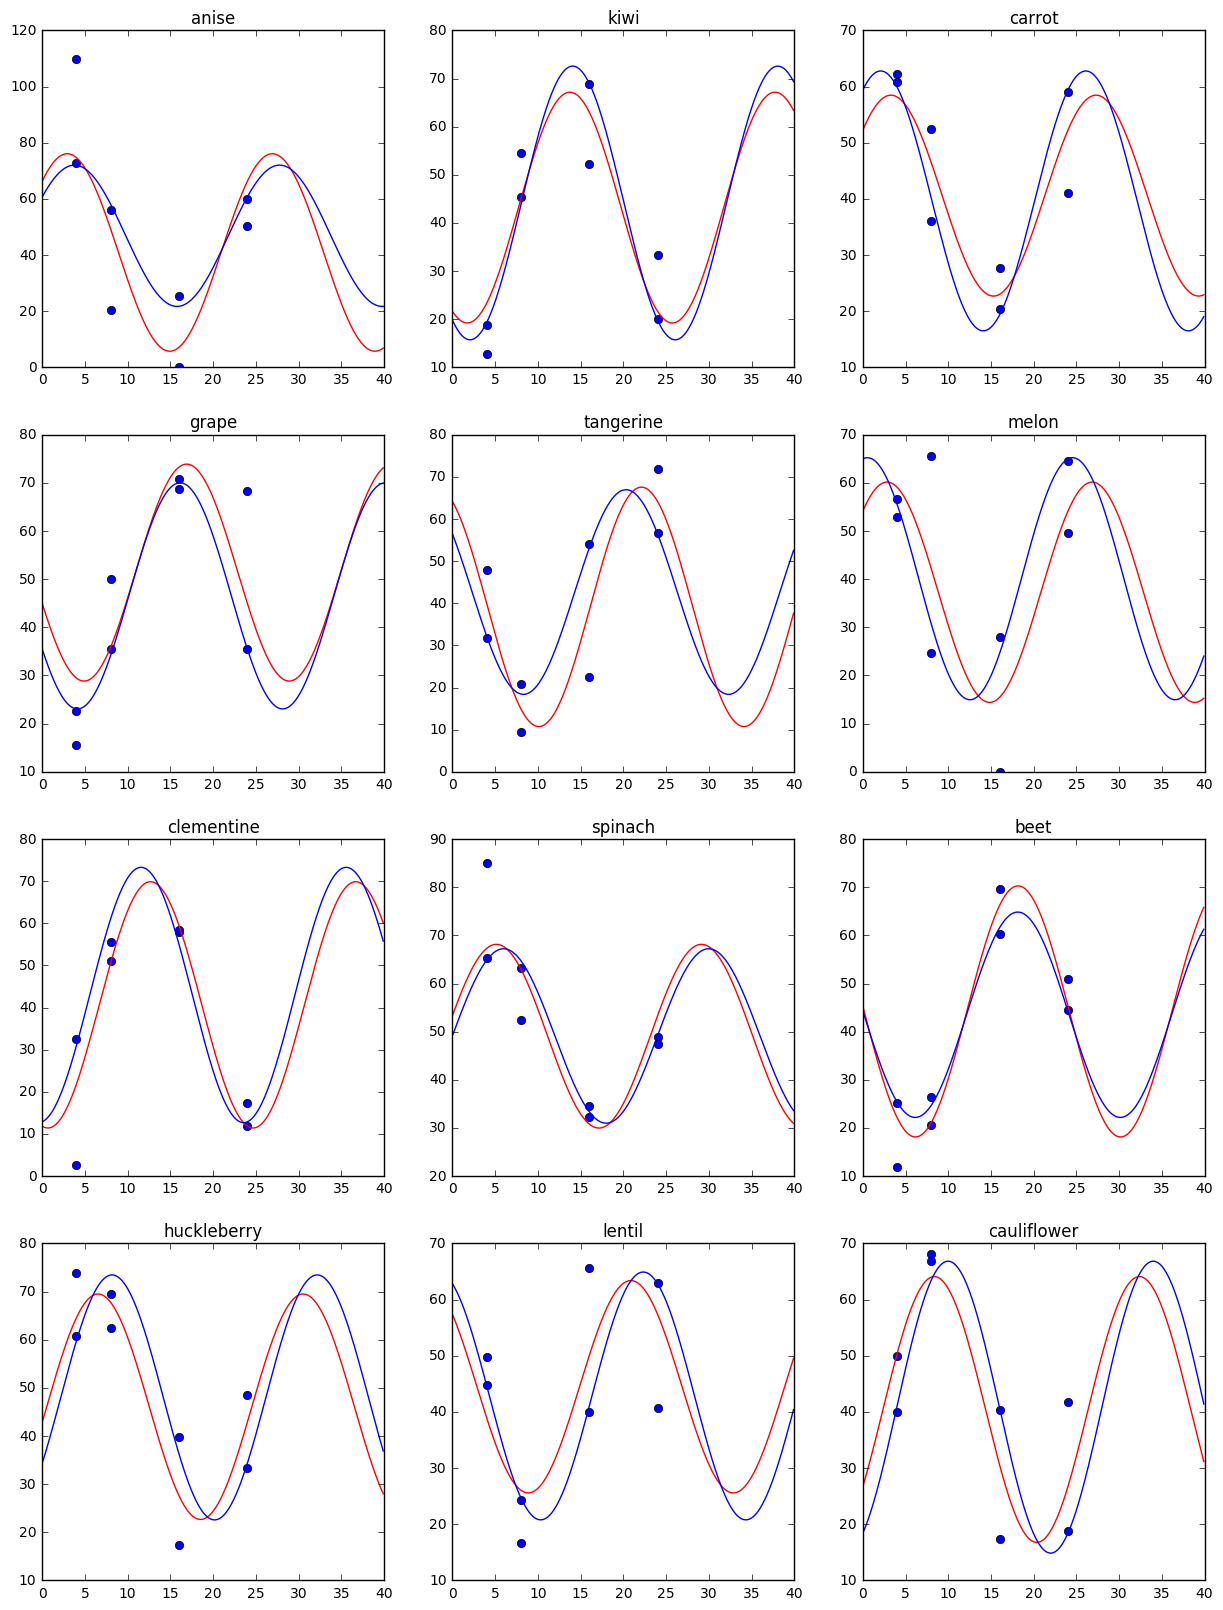

In [84]:
f, ax = plt.subplots(4,3, figsize = (15,20))

l = 0
x_axis = np.arange(0,40.,0.1)

for i in range(4):
    for j in range(3):
        
        y_opt = b_opt[l] + a_opt[l]*np.sin(2. * math.pi * (x_axis + p_opt[l]) / 24)
        y_mor = b_fit[l] + a_fit[l]*np.sin(2. * math.pi * (x_axis + p_fit[l]) / 24)
        
        ax[i,j].plot(X, Y[l], 'o')
        ax[i,j].plot(x_axis, y_mor, 'r-')
        ax[i,j].plot(x_axis, y_opt, 'b-') 
        
        ax[i,j].set_title(genenames[l])


        
        l = l+1
        


It appears that the way that Moriarty has done this overfits to points where the variance is actually fairly high 